In [1]:
# Шаардлагатай сангуудыг импортлох
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Тохиргоо
latent_dim = 64  # Шахалтын хэмжээ
batch_size = 128
learning_rate_ae = 4e-4
learning_rate_cls = 1e-3
epochs_ae = 10
epochs_cls = 10

# GPU эсвэл CPU ашиглах эсэхийг шалгах
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Ашиглаж буй төхөөрөмж: {device}')

Ашиглаж буй төхөөрөмж: cuda


In [2]:
# Датаг хувиргах
transform = transforms.ToTensor()
# MNIST датасетыг татах
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Даталоудерыг бий болгох
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print('Датасет бэлэн боллоо!')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:05<00:00, 1.91MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 114kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 866kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Датасет бэлэн боллоо!


In [ ]:
# Автокодлогчийн загвар
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Кодлогч
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   #(1, 28, 28)->(16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  #(16, 14, 14)->(32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                       #(32, 7, 7)->(64, 1, 1)
        )
        # Декодлогч
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # [-1, 1] завсарт     оруулах
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AEClassifier(nn.Module):
    def __init__(self, ae_encoder, latent_dim, num_classes=10):
        super(AEClassifier, self).__init__()
        # Pre-trained encoder-ийг авах
        self.encoder = ae_encoder
        # Encoder-ийн жингийн утгуудыг freeze хийх нь
        for param in self.encoder.parameters():
            param.requires_grad = False
        # Ангилал хийх layers
        self.classifier = nn.Sequential(
            nn.Flatten(), # 64x1x1 -> 64 болгоно
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) # 10 ангилал (0-9)
        )
    # Кодлогчийг ашиглан latent space-ийг авах
    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.classifier(encoded)
        return logits
    
# Загвар 1-ыг бий болгох
print('\n- - - 1. Autoencoder-ийг сургах нь - - - ')
ae_model = Autoencoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(ae_model.parameters(), lr=learning_rate_ae)

print('Загвар бэлэн боллоо!')


- - - 1. Autoencoder-ийг сургах нь - - - 
Загвар бэлэн боллоо!


In [4]:
# Сургалтын функц
def train_ae(model, train_loader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avgLoss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Алдагдал: {total_loss/len(train_loader):.4f}')
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avgLoss
            }, f"checkpoint_epoch_{epoch+1}.pth")

            print(f"Хадгаллаа: checkpoint_epoch_{epoch+1}.pth")

# Сургалтыг эхлүүлэх
train_ae(ae_model, train_loader, criterion_ae, optimizer_ae, epochs_ae, device)

Epoch 1/10, Алдагдал: 0.0483
Epoch 2/10, Алдагдал: 0.0124
Epoch 3/10, Алдагдал: 0.0078
Epoch 4/10, Алдагдал: 0.0060
Epoch 5/10, Алдагдал: 0.0052
Epoch 6/10, Алдагдал: 0.0046
Epoch 7/10, Алдагдал: 0.0043
Epoch 8/10, Алдагдал: 0.0040
Epoch 9/10, Алдагдал: 0.0038
Epoch 10/10, Алдагдал: 0.0036
Хадгаллаа: checkpoint_epoch_10.pth


In [5]:
print('\n- - - 2. AE-д суурилсан ангилагчийг сургах нь - - -')

# AE сургагдсан тул түүний Encoder-ийг ашиглан Classifier үүсгэнэ
classifier_model = AEClassifier(ae_model.encoder, latent_dim).to(device) 
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier_model.parameters(), lr=learning_rate_cls)

# Сургалтын функц (Classifier)
def train_classifier(model, train_loader, criterion, optimizer, epochs, device):
    model.train()
    print("Classifier сургалт эхэллээ...")
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Accuracy тооцоолох
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
        print(f'Classifer эпоч {epoch+1}/{epochs}, Алдагдал: {total_loss/len(train_loader):.4f}, Оновчтой байдал: {100*correct/total:.2f}%')

# Classifier сургалтыг эхлүүлэх
train_classifier(classifier_model, train_loader, criterion_cls, optimizer_cls, epochs_cls, device)


- - - 2. AE-д суурилсан ангилагчийг сургах нь - - -
Classifier сургалт эхэллээ...
Classifer эпоч 1/10, Алдагдал: 0.5822, Оновчтой байдал: 81.99%
Classifer эпоч 2/10, Алдагдал: 0.2890, Оновчтой байдал: 91.54%
Classifer эпоч 3/10, Алдагдал: 0.2295, Оновчтой байдал: 93.11%
Classifer эпоч 4/10, Алдагдал: 0.2007, Оновчтой байдал: 94.06%
Classifer эпоч 5/10, Алдагдал: 0.1804, Оновчтой байдал: 94.63%
Classifer эпоч 6/10, Алдагдал: 0.1697, Оновчтой байдал: 94.92%
Classifer эпоч 7/10, Алдагдал: 0.1587, Оновчтой байдал: 95.22%
Classifer эпоч 8/10, Алдагдал: 0.1564, Оновчтой байдал: 95.32%
Classifer эпоч 9/10, Алдагдал: 0.1474, Оновчтой байдал: 95.57%
Classifer эпоч 10/10, Алдагдал: 0.1428, Оновчтой байдал: 95.68%



- - - 3. Latent Space Cluster Map үүсгэх - - -
t-SNE тооцоолол хийгдэж байна (түр хүлээнэ үү)...


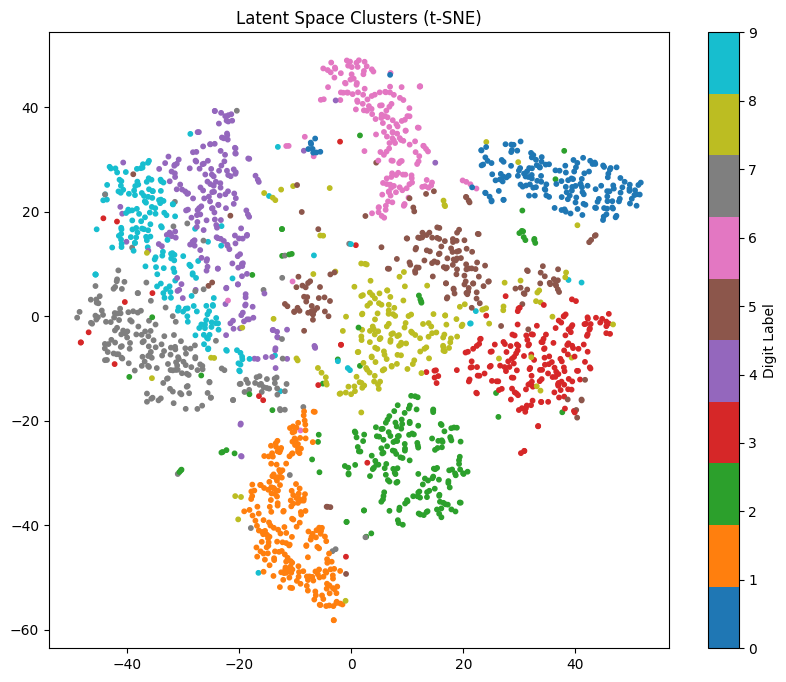

In [ ]:
print('\n- - - 3. Latent Space Cluster Map үүсгэх - - -')

def plot_latent_space(encoder, test_loader, device):
    encoder.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            encoded = encoder(data).cpu().numpy()
            # (batch, 64, 1, 1) -> (batch, 64)
            encoded = encoded.reshape(encoded.shape[0], -1) 
            latent_vectors.append(encoded)
            labels.append(target.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    print("t-SNE тооцоолол хийгдэж байна (түр хүлээнэ үү)...")
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors[:2000]) # Хурдан болгохын тулд эхний 2000 өгөгдлийг ашиглав

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:2000], cmap='tab10', s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.title('Latent Space Clusters (t-SNE)')
    plt.show()

plot_latent_space(ae_model.encoder, test_loader, device)


--- Full Test Set Evaluation (AE-Classifier) ---
Test Loss: 0.0779
Test Accuracy: 97.66%

--- 50-Sample Visualization (True Label vs. Predicted) ---


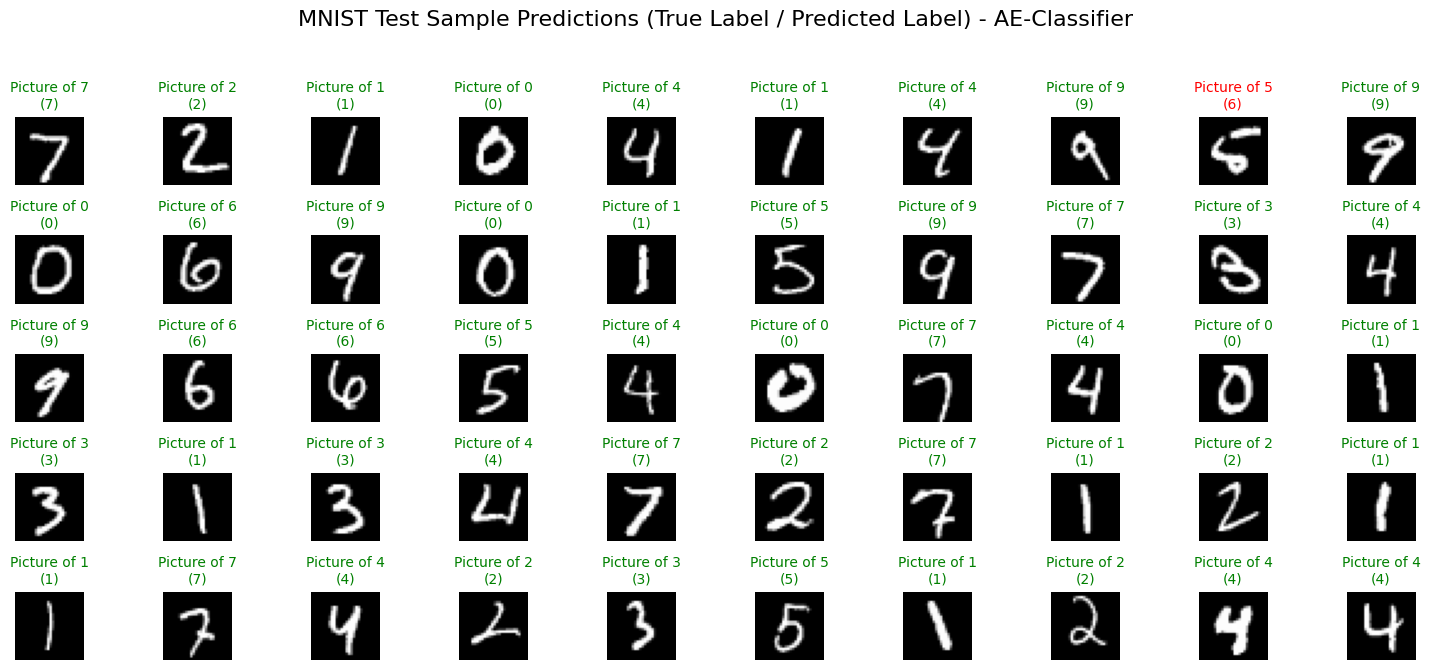

In [ ]:
## --- Гаралт 2: classification үнэлгээ ---
import torchvision.datasets 
import torchvision.transforms as transforms

MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
transform_test = transforms.ToTensor()

def evaluate_and_visualize(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_images = []
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_images.append(inputs.cpu())
            all_true_labels.append(labels.cpu())
            all_predicted_labels.append(predicted.cpu())
            
    print(f"Тестын лосс: {test_loss/len(test_loader):.4f}")
    print(f"Тестын оновчтой байдал: {100*correct/total:.2f}%")

    print("\n- - - 50 samples дээрх жишээ - - -")
    
    images = torch.cat(all_images, dim=0)[:50]
    true_labels = torch.cat(all_true_labels, dim=0)[:50]
    predicted_labels = torch.cat(all_predicted_labels, dim=0)[:50]

    images_np = images.squeeze().numpy()
    true_labels_np = true_labels.numpy()
    predicted_labels_np = predicted_labels.numpy()

    fig, axes = plt.subplots(5, 10, figsize=(15, 7))
    axes = axes.flatten()

    for i in range(50):
        img = images_np[i]
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        
        true_label = true_labels_np[i]
        predicted_label = predicted_labels_np[i]

        title = f"{true_label}-ын тоо\n(Таамарласан:{predicted_label})"
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(title, fontsize=10, color=color)
        ax.axis('off')

    plt.suptitle("MNIST Тестын 50 sample дээрх таамаглалууд", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Үнэлгээг ажиллуулах
evaluate_and_visualize(classifier_model, test_loader, criterion_cls, device)